# Code Section

Load all shared code for the analysis.


In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from io import StringIO

In [3]:
def converte_para_data(df, col):

    mes_map = {
        "janeiro": "01", "fevereiro": "02", "março": "03", "abril": "04",
        "maio": "05", "junho": "06", "julho": "07", "agosto": "08",
        "setembro": "09", "outubro": "10", "novembro": "11", "dezembro": "12"
    }

    df[col] = (
        df[col]
        .str.strip()
        .str.lower()
        .str.replace(r"(\w+)\s+(\d{4})", lambda m: f"{m.group(2)}-{mes_map[m.group(1)]}-01", regex=True)
        .pipe(pd.to_datetime, format="%Y-%m-%d")
    )
    


## Banco Central do Brasil - API séries históricas.

In [4]:
#URL base da API de séries históricas do Banco Central do Brasil.
BCB_SGS_API_URL = r'https://api.bcb.gov.br/dados'

# Código das séries históricas no SGS do BC. Os códigos podem ser acessados através da página do SGS do BC.
SGS_INPC: int = 188
SGS_IPCA: int = 433

# Recupera dados de série histórica do banco central, atrávés do código da série.
def get_sgs_data(serie):
  url = r'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(serie)
  df: pd.DataFrame = pd.read_json(url)
  return df


## IBGE - API SIDRA

### Parâmetros de consulta da API SIDRA

* Os parâmetros V e P permitem a seleção das variáveis e o período de tempo, respectivamente.
* Parâmetros iniciados por C são utilizados para selecionar classificações e suas categorias.<br> As classificações disponíveis variam de acordo com a tabela, até um máximo de 6.
* Para especificação do território, pode-se utilizar o parâmetro  G  para identificar uma visão territorial predefinida, ou então um ou mais parâmetros do tipo N para indicar um nível territorial e suas unidades. Os tipos de parâmetro (G ou N) são excludentes entre si não podendo ser utilizados simultaneamente em uma mesma consulta.

-----

### Parâmetros de dimensão

| Parâmetro | Descrição      | Utilização |
| --------- | -------------- | ---------- |
| **T**  | Especifica a tabela de onde se deseja extrair os dados. | O parâmetro T deve ser seguido pelo código numérico da tabela SIDRA. Este parâmetro é obrigatório, pois a tabela indicada servirá de base para todos os outros parâmetros da consulta.<br> Exemplo: /t/1612 |
| **P**  | Especifica os períodos (meses, anos etc.). a serem pesquisados| O parâmetro P é opcional e, caso não seja especificado, assumirá o valor default **/p/last** (vide adiante).<p> O parâmetro P pode ser seguido pela constante all para selecionar todos os períodos disponíveis para a tabela.<br> Exemplo 1: /p/all <br><br> O parâmetro P pode ser seguido pela constante first e um número, para indicar os primeiros períodos disponíveis para a tabela (períodos mais antigos). O número de períodos pode ser omitido quando se tratar de apenas um período.<br> Exemplo 2: /p/first 12<br> Exemplo 3: /p/first (equivalente a /p/first 1)<br><br> O parâmetro P pode ser seguido pela constante last e um número, para indicar os últimos períodos disponíveis para a tabela (períodos mais recentes). O número de períodos pode ser omitido quando se tratar de apenas um período.<br> Exemplo 4: /p/last 12<br> Exemplo 5: /p/last (equivalente a /p/last 1)<br><br> O parâmetro P pode especificar códigos de períodos de forma avulsa (separados por vírgula ","), em faixas (separados por traço "-"), ou de ambas as formas. Para mais detalhes sobre os códigos de períodos, consulte a nota adiante.<br> Exemplo 6: /p/2008,2009,2010 – especifica os anos 2008, 2009 e 2010.<br> Exemplo 7: /p/2008,2010-2014 – especifica o ano de 2008, e os anos no intervalo de 2010 a 2014.<br> Exemplo 8: /p/201101-201112,201204,201208 – especifica os meses de janeiro a dezembro de 2011, abril de 2012 e agosto de 2012.|
| **V**  | Especifica os parâmetros de consulta. | O parâmetro V é opcional e, caso não seja especificado, assumirá o valor default /p/allxp (vide adiante).<br><br> O parâmetro V pode ser seguido pela constante all para especificar todas as variáveis da tabela, inclusive as variáveis de percentual geradas automaticamente pelo Sidra.<br> Exemplo 1: /v/all <br><br> O parâmetro V pode ser seguido pela constante allxp para especificar todas as variáveis da tabela, exceto as variáveis de percentual geradas automaticamente pelo Sidra.<br> Exemplo 2: /v/allxp<br><br> O parâmetro V pode ser seguido por uma lista de códigos de variáveis (separados por vírgula ",").<br> Exemplo 3: /v/63,69 seleciona as variáveis "Variação mensal" e "Variação acumulada ao ano".<br> Exemplo 4: /v/109,1000109 – seleciona a variável "Área Plantada" e a variável calculada "Área plantada - percentual do total geral". |
| **G**  | Especifica uma visão territorial para a consulta. | O parâmetro G deve ser seguido pelo código da visão territorial de interesse.<br> Exemplo: /g/44 – seleciona os valores para a visão territorial "Brasil e Grande Região". |
| **Ni** | Especifica níveis territoriais e suas unidades para a consulta. | O valor de Ni identifica o nível territorial (por exemplo N1 – Brasil, N2 – Grande Região, N3 – Unidade da Federação, N6 – Município, etc), e é seguido por uma seleção de unidades territoriais a serem consultadas. Este parâmetro pode ser utilizado mais de uma vez para especificar unidades territoriais em níveis distintos.<br> O parâmetro Ni pode ser seguido pela constante all para especificar todas as unidades territoriais deste nível disponíveis para a tabela.<br> Exemplo 1: /n3/all – especifica todas as unidades da federação.<br> Exemplo 2: /n6/all – especifica todos os municípios.<br><br> O parâmetro Ni pode ser seguido por uma lista de unidades territoriais especificadas por seus códigos IBGE (separados por vírgula ",").<br> Exemplo 3: /n3/33,35 – especifica as UFs Rio de Janeiro e São Paulo.<br> Exemplo 4: /n6/3304557,3550308 – especifica os municípios Rio de Janeiro e São Paulo.<br><br> O parâmetro Ni pode ser seguido pela expressão IN Nj antecedendo a lista de unidades territoriais, para que estas sejam tratadas como uma abrangência territorial. Em outras palavras, estaremos selecionando unidades territoriais do nível Ni, contidas em unidades territoriais de um nível superior Nj.<br> Exemplo 5: /n6/in n3 11,12 - especifica os municípios (N6) contidos nas Unidades da Federação (N3) Rondônia e Acre.<br> Exemplo 6: /n3/in n2 3,4 – especifica as Unidades da Federação (N3) contidas nas Grandes Regiões (N2) Sudeste e Sul.<br><br> O parâmetro Ni pode ser utilizado mais de uma vez caso sejam selecionadas unidades territoriais em níveis distintos.<br> Exemplo 7: /n1/1/n2/1/n3/in n2 1 – especifica Brasil (N1/1), a Grande Região Norte (N2/1) e as UFs contidas na Grandes Região Norte (N3/IN N2 1). |
| **Ci** | Especifica as classificações da tabela e suas categorias. | O valor de Ci identifica uma classificação da tabela (por exemplo C1 – Situação do domicílio, C2 – Sexo, C81 – Produtos da Lavoura Temporária, etc), e é seguido por uma seleção de categorias a serem consultadas.<br><br> O parâmetro Ci é opcional e, caso uma classificação não seja especificada, será assumida para ela a categoria que representa o total. Se esta categoria não existir na classificação, a consulta retornará o símbolo de que os valores não se aplicam (".." , vide ao final).<br><br> O parâmetro Ci pode ser seguido pela constante all para especificar todas as categorias disponíveis para uma classificação, inclusive a categoria que representa o total.<br> Exemplo 1: /c81/all – especifica todos os produtos da lavoura temporária, incluindo o total. O parâmetro Ci pode ser seguido pela constante allxt para especificar todas as categorias disponíveis para uma classificação, exceto a categoria que representa o total.<br> Exemplo 2: /c81/allxt – especifica todos os produtos da lavoura temporária, sem incluir o total.<br><br> O parâmetro Ci pode ser seguido por uma lista de categorias especificadas através de seus códigos, de forma individual (separados por vírgula ",") ou para compor uma soma (separadas por espaço " ").<br> Exemplo 3: /c81/2692,2702,2694 2695 – especifica os produtos da lavoura temporária arroz e feijão, e a soma de batata doce com batata inglesa. |

<br>

  > [Notas]<br>
  > T:<br>
  > O formato de um código de período é determinado pela periodicidade de liberação da tabela SIDRA consultada. Para tabelas de divulgação anual, o código possui 4 dígitos no formato AAAA, e indica o ano da ocorrência desejada. Para os demais casos, o código de período possui 6 dígitos no formato AAAASS, onde AAAA indica o ano e SS número de sequência da ocorrência que, conforme a periodicidade, pode representar um mês (01 a 12), um trimestre (01 a 04), um semestre (01 ou 02), entre outros.<br><br>
  > P:<br>
  > Variáveis com códigos superiores a 1.000.000 identificam variáveis de percentual calculadas automaticamente. A disponibilidade de uma variável derivada deve ser consultada para cada tabela.<br><br>
  > G:<br>
  > A disponibilidade de dados para uma determinada visão territorial deve ser consultada para cada tabela. Todas as unidades territorais da visão serão apresentadas na tabela de resultado, mesmo quando não houver disponibilidade. Nestes casos, o valor "..." será retornado. Quando utilizado o parâmetro G, não será possível utilizar o parâmetro Ni para especificar níveis territoriais avulsos.<br><br>
  > N:<br>
  > A disponibilidade de dados para um determinado nível territorial deve ser consultada para cada tabela. A consulta, por padrão, não retorna unidades territoriais extintas. Caso seja necessário obter valores também para territórios extintos, tanto para consultas do tipo /all quanto por código (por exemplo as UFs Fernando de Noronha - 20 e Guanabara - 34), deve-se acrescentar na lista de parâmetros da consulta /u/y.<br>
  > Quando utilizado o parâmetro Ni, não será possível utilizar o parâmetro G para especificar uma visão territorial pré-definida.

In [5]:
# URL base para a API SIDRA
SIDRA_BASE_URL = 'https://apisidra.ibge.gov.br/values'

# Tableas de dados API SIDRA

# Tabela 1737: IPCA - Série histórica com número-índice, variação mensal e variações acumuladas em 3 meses, 
# em 6 meses, no ano e em 12 meses (a partir de dezembro/1979)

#Tabela 7060: IPCA - Variação mensal, acumulada no ano, acumulada em 12 meses e peso mensal, para o índice 
# geral, grupos, subgrupos, itens e subitens de produtos e serviços (a partir de janeiro/2020)

SIDRA_INPC_TABLEID = 1736
SIDRA_IPCA_TABLEID = 1737


In [6]:
# Recupera dados das tabelas do sistema SIDRA do IBGE
def get_sidra_data(table_id, params):
    param_str:str = "/".join([f"{key}/{value}" for key, value in params.items()])
    url: str = f"{SIDRA_BASE_URL}/t/{table_id}/{param_str}"
    try:
         response: requests.Response = requests.get(url)
         response.raise_for_status()  # Lança uma exceção para códigos de erro HTTP
         data = response.json()
         df: pd.DataFrame = pd.DataFrame(data)
         return df
    except requests.exceptions.RequestException as e:
         print(f"Erro ao fazer a requisição: {e}")
    except (ValueError, KeyError) as e:
         print(f"Erro ao processar o JSON recebido: {e}")
    except Exception as e:
         print(f"Ocorreu um erro inesperado: {e}")
    return None

In [17]:
# Recupera o número indice do IPCA dos últimos N meses
def get_ipca_indice_geral(ultimos_meses=12):
    
    """
    Busca a variação mensal do IPCA (Índice Geral) para o Brasil na API do IBGE (SIDRA)
    utilizando o formato JSON.

    :param ultimos_meses: O número de últimos meses a serem buscados.
    :return: Um DataFrame do Pandas com os dados ou None em caso de erro.
    """
    # Tabela 1737: IPCA - Variação mensal.
    # Variável 2266: IPCA - Índice Geral.
    # Nível Territorial N1/1: Brasil.
    # Período: /p/last%20{ultimos_meses} -> Últimos N meses.

        # Variação IPCA 12 messes

    SIDRA_IPCA_PARAMS = {
        'n1': '1',
        'v' : '2266',
        'p' : f'last {ultimos_meses}',
        'd' : '2'
    }

    df = get_sidra_data(SIDRA_IPCA_TABLEID,SIDRA_IPCA_PARAMS)
    df_indice_geral = df[['D3N','V']]
    
    # Renomeia as colunas de interesse
    df_indice_geral.rename(columns={
        'D3N':'mes',
        'V':'indice_geral'
    }, inplace=True)

    df_indice_geral = df_indice_geral.iloc[1:]
    
    # Converte a coluna de variação para tipo numérico
    df_indice_geral['indice_geral'] = pd.to_numeric(df_indice_geral['indice_geral'], errors='coerce')
    converte_para_data(df_indice_geral,'mes')
    
    return df_indice_geral
    

In [7]:

#Recupera o IPCA variação mensal dos últimos N meses
def get_ipca_variacao_mensal(ultimos_meses=12):
    
    """
    Busca a variação mensal do IPCA (Índice Geral) para o Brasil na API do IBGE (SIDRA)
    utilizando o formato JSON.

    :param ultimos_meses: O número de últimos meses a serem buscados.
    :return: Um DataFrame do Pandas com os dados ou None em caso de erro.
    """
    # Tabela 1737: IPCA - Variação mensal.
    # Variável 63: IPCA - Variação mensal.
    # Classificação C315/7169: Índice geral.
    # Nível Territorial N1/1: Brasil.
    # Período: /p/last%20{ultimos_meses} -> Últimos N meses.

    # Variação IPCA 12 messes

    SIDRA_IPCA_PARAMS = {
        'n1': '1',
        'v' : '63',
        'p' : f'last {ultimos_meses}'
    }

    df = get_sidra_data(SIDRA_IPCA_TABLEID,SIDRA_IPCA_PARAMS)
    df_variacao_mes = df[['D3N','V']]
    
    # Renomeia as colunas de interesse
    df_variacao_mes.rename(columns={
        'D3N':'mes',
        'V':'variacao_mensal'
    }, inplace=True)

    df_variacao_mes = df_variacao_mes.iloc[1:]
    
    # Converte a coluna de variação para tipo numérico
    df_variacao_mes['variacao_mensal'] = pd.to_numeric(df_variacao_mes['variacao_mensal'], errors='coerce')
    converte_para_data(df_variacao_mes,'mes')
    
    return df_variacao_mes

## IBGE - API Dados Agregados

In [8]:
# URL base da API de dados agregados do IBGE.
agregados_base_url = r'https://servicodados.ibge.gov.br/api/v3/agregados'

# Data Section

## Preços e custos

Compreende as informações sobre as variações de preços dos bens e serviços produzidos na economia, abrangendo índices de preços ao consumidor, índices de preços ao produtor, e, ainda, comparações internacionais, visando medir as paridades de poder de compra e os níveis correspondentes de preço e volume do Produto Interno Bruto - PIB, entre outros aspectos. Compreende também as informações sobre custos e índices da construção civil.

### IPCA - Índice Nacional de Preços ao Consumidor Amplo

https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=o-que-e


O Índice Nacional de Preços ao Consumidor Amplo – IPCA que tem por objetivo medir a inflação de um conjunto de produtos e serviços comercializados no varejo, referentes ao consumo pessoal das famílias. Esta faixa de renda foi criada com o objetivo de garantir uma cobertura de 90% das famílias pertencentes às áreas urbanas de cobertura do Sistema Nacional de Índices de Preços ao Consumidor - SNIPC.

Esse índice de preços tem como unidade de coleta estabelecimentos comerciais e de prestação de serviços, concessionária de serviços públicos e intenet e sua coleta estende-se, em geral, do dia 01 a 30 do mês de referência.

Atualmente, a população-objetivo do IPCA abrange as famílias com rendimentos de 1 a 40 salários mínimos, qualquer que seja a fonte, residentes nas áreas urbanas das regiões de abrangência do SNIPC, as quais são: regiões metropolitanas de Belém, Fortaleza, Recife, Salvador, Belo Horizonte, Vitória, Rio de Janeiro, São Paulo, Curitiba, Porto Alegre, além do Distrito Federal e dos municípios de Goiânia, Campo Grande, Rio Branco, São Luís e Aracaju.

In [9]:
# Exibe a variação mensal do IPCA nos últimos 12 meses
df_ipca = get_ipca_variacao_mensal(12)
df_ipca

C:\Users\Alexandre Fukaya\AppData\Local\Temp\ipykernel_9084\2331286187.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_variacao_mes.rename(columns={


,mes,variacao_mensal
1,2025-01-01,0.16
2,2025-02-01,1.31
3,2025-03-01,0.56
4,2025-04-01,0.43
5,2025-05-01,0.26
6,2025-06-01,0.24
7,2025-07-01,0.26
8,2025-08-01,-0.11
9,2025-09-01,0.48
10,2025-10-01,0.09


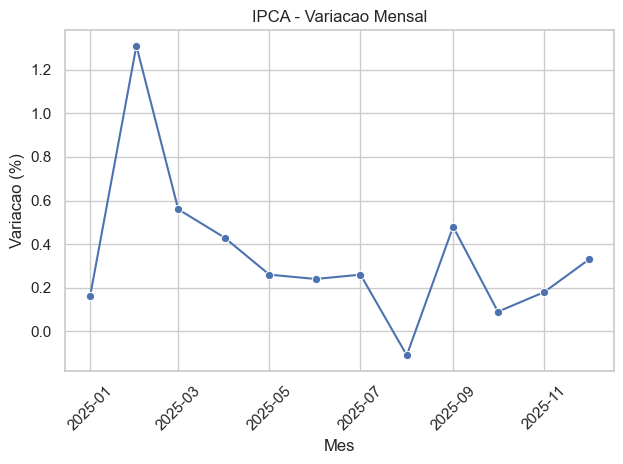

In [10]:
df_plot = df_ipca.sort_values('mes').copy()

sns.set_theme(style='whitegrid')
ax = sns.lineplot(
    data=df_plot,
    x='mes',
    y='variacao_mensal',
    marker='o'
)

ax.set_title('IPCA - Variacao Mensal')
ax.set_xlabel('Mes')
ax.set_ylabel('Variacao (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
df_ipca = get_ipca_indice_geral(12)
df_ipca

C:\Users\Alexandre Fukaya\AppData\Local\Temp\ipykernel_9084\3615045132.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indice_geral.rename(columns={


,mes,indice_geral
1,2025-01-01,7111.86
2,2025-02-01,7205.03
3,2025-03-01,7245.38
4,2025-04-01,7276.54
5,2025-05-01,7295.46
6,2025-06-01,7312.97
7,2025-07-01,7331.98
8,2025-08-01,7323.91
9,2025-09-01,7359.06
10,2025-10-01,7365.68


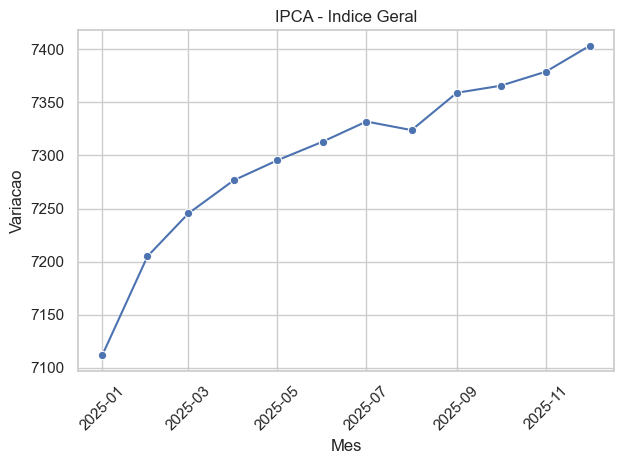

In [20]:
df_plot = df_ipca.sort_values('mes').copy()

sns.set_theme(style='whitegrid')
ax = sns.lineplot(
    data=df_plot,
    x='mes',
    y='indice_geral',
    marker='o'
)

ax.set_title('IPCA - Indice Geral')
ax.set_xlabel('Mes')
ax.set_ylabel('Variacao')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### INPC - Índice Nacional de Preços ao Consumidor

O Índice Nacional de Preços ao Consumidor – INPC que tem por objetivo a correção do poder de compra dos salários, através da mensuração das variações de preços da cesta de consumo da população assalariada com mais baixo rendimento. Esta faixa de renda foi criada com o objetivo de garantir uma cobertura populacional de 50% das famílias cuja pessoa de referência é assalariada e pertencente às áreas urbanas de cobertura do SNIPC - Sistema Nacional de Índices de Preços ao Consumidor.

Esse índice de preços tem como unidade de coleta estabelecimentos comerciais e de prestação de serviços, concessionária de serviços públicos e internet e sua coleta estende-se, em geral, do dia 01 a 30 do mês de referência.

Atualmente, a população-objetivo do INPC abrange as famílias com rendimentos de 1 a 5 salários mínimos, cuja pessoa de referência é assalariada, residentes nas áreas urbanas das regiões de abrangência do SNIPC, as quais são: regiões metropolitanas de Belém, Fortaleza, Recife, Salvador, Belo Horizonte, Vitória, Rio de Janeiro, São Paulo, Curitiba, Porto Alegre, além do Distrito Federal e dos municípios de Goiânia, Campo Grande, Rio Branco, São Luís e Aracaju.